In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [193]:
#merge 12months of data into a single file for the year 
filepaths = [f for f in os.listdir('.')]
df = pd.concat(map(pd.read_csv, filepaths))


In [194]:
df.columns = ['orderID', 'product', 'qty', 'price', 'date', 'address'] #rename col headings 
df.dropna(inplace=True) #drop null values 
df = df[df['price'].str.contains('Price Each')==False] #filter out erroneous col headers and reassign  
df['price'] = pd.to_numeric(df['price'], errors='coerce') #format price as numeric 
df['qty'] = pd.to_numeric(df['qty'], errors='coerce') #format qty as numeric 

In [195]:
#Q1 - which month was best for sales? what were the takings? A1 - December, 4.613e+06 USD 
df['sales'] = df['price'] * df['qty'] #sales = price * qty 
df['datetime'] = pd.to_datetime(df['date'], errors='coerce') #parse date into datetime format 
monthly_sales = df.groupby(df['datetime'].dt.month)['sales'].sum() #group by month, sum sales, select best

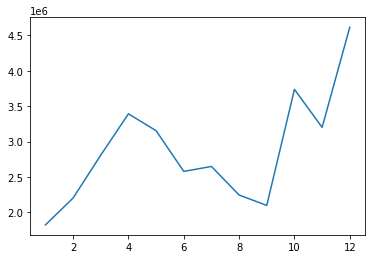

In [196]:
plt.plot(monthly_sales)
plt.show()

In [197]:
#Q2 - which city had the most sales? A2 - San Francisco, 8.26e+06 USD 
new = df['address'].str.split(',', expand=True) #split address on commas 
df['street'], df['city'], df['zip'] = new[0], new[1], new[2] #assign split of address to street, city, zip
df.drop(columns=['address', 'date'], inplace=True) #drop redundant columns 
city_sales = df.groupby(df['city'])['sales'].sum() #group by city, sum sales, select best
print(city_sales) 

city
 Atlanta          2.795499e+06
 Austin           1.819582e+06
 Boston           3.661642e+06
 Dallas           2.767975e+06
 Los Angeles      5.452571e+06
 New York City    4.664317e+06
 Portland         2.320491e+06
 San Francisco    8.262204e+06
 Seattle          2.747755e+06
Name: sales, dtype: float64


In [198]:
temp = df['zip'].str.split(' ', expand=True) #split state and zip
df['state'], df['zipcode'] = temp[1], temp[2] #new features: state and zipcode
df['city'] = df['city'] + ' ' + df['state'] #combining city and state
df.drop(columns=['zip', 'state'], inplace=True) 
df.head()

,orderID,product,qty,price,sales,datetime,street,city,zipcode
0,295665,Macbook Pro Laptop,1,1700.00,1700.00,2019-12-30 00:01:00,136 Church St,New York City NY,10001
1,295666,LG Washing Machine,1,600.00,600.00,2019-12-29 07:03:00,562 2nd St,New York City NY,10001
2,295667,USB-C Charging Cable,1,11.95,11.95,2019-12-12 18:21:00,277 Main St,New York City NY,10001
3,295668,27in FHD Monitor,1,149.99,149.99,2019-12-22 15:13:00,410 6th St,San Francisco CA,94016
4,295669,USB-C Charging Cable,1,11.95,11.95,2019-12-18 12:38:00,43 Hill St,Atlanta GA,30301


In [205]:
df.groupby(df['city']).sum()

,qty,price,sales
city,,,
Atlanta GA,16602,2.779908e+06,2.795499e+06
Austin TX,11153,1.809874e+06,1.819582e+06
Boston MA,22528,3.637410e+06,3.661642e+06
Dallas TX,16730,2.752628e+06,2.767975e+06
Los Angeles CA,33289,5.421435e+06,5.452571e+06
New York City NY,27932,4.635371e+06,4.664317e+06
Portland ME,2750,4.471893e+05,4.497583e+05
Portland OR,11303,1.860558e+06,1.870732e+06
San Francisco CA,50239,8.211462e+06,8.262204e+06


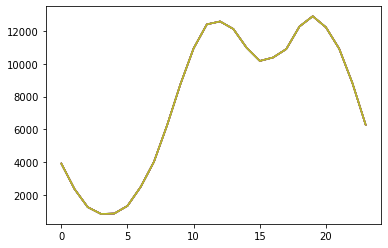

In [216]:
#Q3 - when are customers most likely to buy something? A3 - peaks at ~10am and 7pm 
df['order_hour'] = df['datetime'].dt.hour 
hourly_orders = df.groupby(df['order_hour']).count()
plt.plot(hourly_orders)
plt.show()

In [223]:
#Q4 - which products are commonly purchased together? 
dup_df = df[df['orderID'].duplicated(keep=False)] #find duplicates - orders with multiple purchases
dup_df['basket'] = dup_df.groupby('orderID')['product'].transform(lambda x: ','.join(x)) #add products to basket
dup_df = dup_df[['orderID', 'basket']].drop_duplicates() 

<ipython-input-223-1c9cf1980e3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup_df['basket'] = dup_df.groupby('orderID')['product'].transform(lambda x: ','.join(x))


In [231]:
from itertools import combinations
from collections import Counter

count = Counter()
for row in dup_df['basket']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

count.most_common(5)


[(('iPhone', 'Lightning Charging Cable'), 1005),
 (('Google Phone', 'USB-C Charging Cable'), 987),
 (('iPhone', 'Wired Headphones'), 447),
 (('Google Phone', 'Wired Headphones'), 414),
 (('Vareebadd Phone', 'USB-C Charging Cable'), 361)]

In [232]:
#Q5 - which product sold the most? (qty) A5 - AAA batteries 
df.groupby('product')['qty'].sum()

product
20in Monitor                   4129
27in 4K Gaming Monitor         6244
27in FHD Monitor               7550
34in Ultrawide Monitor         6199
AA Batteries (4-pack)         27635
AAA Batteries (4-pack)        31017
Apple Airpods Headphones      15661
Bose SoundSport Headphones    13457
Flatscreen TV                  4819
Google Phone                   5532
LG Dryer                        646
LG Washing Machine              666
Lightning Charging Cable      23217
Macbook Pro Laptop             4728
ThinkPad Laptop                4130
USB-C Charging Cable          23975
Vareebadd Phone                2068
Wired Headphones              20557
iPhone                         6849
Name: qty, dtype: int64